# SL-Capstone Project - Battle of the Neighborhoods
## By Sohail L
### June 2020
#### Covid-19 Learning

**Recap of the Problem:** 
- Somerville is a unique neighborhood in New York.
- Fresh Tiki is a famous vegan restaurant that has achieved commercial success in Somerville.
- The owner of Fresh Tiki, Mr. Xi, has recently been approached by Ms. Varga, a prominent Toronto businesswoman, to open 5 locations of Fresh Tiki in Toronto.  Mr. Xi is amenable to opening such locations on a franchise basis, but wants to provide consent regarding locations.  
- Mr. Xi is a firm believer in Somerville and he believes that the eclectic nature of the neighborhood, with its high walkability and suburban feel, have been strong contributors to the success of Fresh Tiki.  Therefore, one of his requirements is that Fresh Tiki be opened in similar locations in Toronto.
- Mr. Xi wants to shortlist up to 10 locations to serve as the initial neighborhoods for opening Fresh Tiki in Toronto.

**Our objective is to assist Mr. Xi using data science and machine learning techniques to short-list the locations.**

We will do this by: 
1. Using data regarding New York neighborhoods, Toronto neighborhoods.
2. Using Foursquare to explore those neighborhoods.
3. Using K-means clustering to cluster neighborhoods.
4. Analyzing the clusters to identify the most similar clusters to Somerville.

**_Data_**

In order to solve this problem, I will be using three possible sources of data:
1. Data regarding Toronto neighborhoods.  This data is available from the following Wikipedia page:
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
This includes data regarding postal codes, boroughs, neighborhoods.

2. Data regarding New York neighborhoods.  The data is available from the following JSON file:
https://cocl.us/new_york_dataset 
This includes data regarding boroughs, neighborhoods.

3. Data in the Foursquare API.  We will make calls to the Foursquare API to explore individual neighborhoods.
 
In order to work with the data, we will have to clean the data in New York and Toronto to remove unassigned neighborhoods.  We will also need to extract locational data (longitude and latitude data) so that we can use it to extract interesting locations in or around the neighborhood from Foursquare API.  This data should be sufficient for us to populate the locations with key characteristics of surroundings of the neighborhood.
Once the data is well organized, we can use an appropriate clustering approach to identify clusters of similar neighborhoods.  We will use the K-means approach.  Based on this clustering, we will assess which cluster Somerville (New York) falls under and what other neighborhoods in Toronto fall under the same cluster.  This should help create a useful short-list, which will be the solution to our problem.


**Before starting, make sure the relevant libraries are downloaded** \
Folium takes a long time on this machine!

In [5]:
# import the relevant libraries

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

import requests 
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

In [6]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

**Step 1: Download and arrange Toronto Data**

In [7]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
df_toronto = pd.read_html(url, attrs={"class": "wikitable"})[0]
df_toronto.head()

Postal Code           Borough               Neighborhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

In [9]:
# ignore cells with a borough that is not assigned.

df_toronto = df_toronto[df_toronto.Borough != 'Not assigned'].reset_index(drop=True)
df_toronto.head()

Postal Code           Borough                                 Neighborhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

In [10]:
df_toronto.shape

(103, 3)

In [11]:
df_coordinates=pd.read_csv('http://cocl.us/Geospatial_data')
df_toronto = pd.merge(df_toronto, df_coordinates, on='Postal Code')
df_toronto.head()

Postal Code           Borough                                 Neighborhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

    Latitude  Longitude  
0  43.753259 -79.329656  
1  43.725882 -79.315572  
2  43.654260 -79.360636  
3  43.718518 -79.464763  
4  43.662301 -79.389494

In [12]:
df_toronto = df_toronto.drop(columns='Postal Code')
df_toronto.head()

Borough                                 Neighborhood   Latitude  \
0        North York                                    Parkwoods  43.753259   
1        North York                             Victoria Village  43.725882   
2  Downtown Toronto                    Regent Park, Harbourfront  43.654260   
3        North York             Lawrence Manor, Lawrence Heights  43.718518   
4  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [13]:
df_toronto.shape

(103, 4)

**Step 2: Download and arrange New York Data**

In [14]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [15]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [16]:
NYneighborhoods_data = newyork_data['features']

In [17]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NYneighborhoods = pd.DataFrame(columns=column_names)

In [18]:
for data in NYneighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NYneighborhoods = NYneighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [19]:
NYneighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [20]:
df_newyork = pd.DataFrame(NYneighborhoods)
df_newyork.shape

(306, 4)

In [21]:
df_toronto.head()

Borough                                 Neighborhood   Latitude  \
0        North York                                    Parkwoods  43.753259   
1        North York                             Victoria Village  43.725882   
2  Downtown Toronto                    Regent Park, Harbourfront  43.654260   
3        North York             Lawrence Manor, Lawrence Heights  43.718518   
4  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [22]:
df_newyork.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

**Step 3: Combine the DataFrames into a single DataFrame**

In [23]:
frames = [df_toronto, df_newyork]
df_combo = pd.concat(frames, keys=['Toronto', 'New York'])

In [24]:
df_combo.head()

Borough                                 Neighborhood  \
Toronto 0        North York                                    Parkwoods   
        1        North York                             Victoria Village   
        2  Downtown Toronto                    Regent Park, Harbourfront   
        3        North York             Lawrence Manor, Lawrence Heights   
        4  Downtown Toronto  Queen's Park, Ontario Provincial Government   

            Latitude  Longitude  
Toronto 0  43.753259 -79.329656  
        1  43.725882 -79.315572  
        2  43.654260 -79.360636  
        3  43.718518 -79.464763  
        4  43.662301 -79.389494

In [25]:
df_combo.shape

(409, 4)

**Step 4: Use Foursquare API to access location data**

In [26]:
# The code was removed by Watson Studio for sharing.

Your credentials are saved in hidden form


In [27]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
combo_venues = getNearbyVenues(names=df_combo['Neighborhood'],
                                   latitudes=df_combo['Latitude'],
                                   longitudes=df_combo['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [31]:
combo_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              43.753259              -79.329656   
1         Parkwoods              43.753259              -79.329656   
2         Parkwoods              43.753259              -79.329656   
3  Victoria Village              43.725882              -79.315572   
4  Victoria Village              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude     Venue Category  
0         Brookbanks Park       43.751976       -79.332140               Park  
1         GTA Restoration       43.753396       -79.333477    Fireworks Store  
2           Variety Store       43.751974       -79.333114  Food & Drink Shop  
3  Victoria Village Arena       43.723481       -79.315635       Hockey Arena  
4             Tim Hortons       43.725517       -79.313103        Coffee Shop

In [32]:
combo_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               5   
Alderwood, Long Branch                                                  9   
Allerton                                                               26   
Annadale                                                               14   
Arden Heights                                                           4   
Arlington                                                               8   
Arrochar                                                               18   
Arverne                                                                19   
Astoria                                                               100   
Astoria Heights                                                        15   
Auburndale                                                             19   
Bath Beach                                                             46   
Bathurst Manor, Wilson Heights, Downsview North                        20   
Battery Park City                                                      65   
Bay Ridge                                                              83   
Bay Terrace                                                            48   
Baychester                                                             18   
Bayside                                                                77   
Bayswater                                                               2   
Bayview Village                                                         4   
Bedford Park                                                           37   
Bedford Park, Lawrence Manor East                                      24   
Bedford Stuyvesant                                                     29   
Beechhurst                                                             16   
Bellaire                                                               12   
Belle Harbor                                                           16   
Bellerose                                                              21   
Belmont                                                                95   
Bensonhurst                                                            31   
Berczy Park                                                            56   
Bergen Beach                                                            5   
Birch Cliff, Cliffside West                                             4   
Blissville                                                             15   
Bloomfield                                                              4   
Boerum Hill                                                            91   
Borough Park                                                           22   
Breezy Point                                                            4   
Briarwood                                                               9   
Brighton Beach                                                         44   
Broad Channel                                                           5   
Broadway Junction                                                      17   
Brockton, Parkdale Village, Exhibition Place                           23   
Bronxdale                                                              13   
Brooklyn Heights                                                      100   
Brookville                                                              1   
Brownsville                                                            16   
Bulls Head                                                             45   
Bushwick                                                               73   
Business reply mail Processing Centre, South Ce...                     16   
Butler Manor                                                            6   
CN Tower, King and Spadina, Railway Lands, Harb.

In [33]:
print('There are {} uniques categories.'.format(len(combo_venues['Venue Category'].unique())))

There are 463 uniques categories.


**Step 5: Use one-hot encoding and grouping to create dataframe of different locations**

In [34]:
# one hot encoding
combo_onehot = pd.get_dummies(combo_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
combo_onehot['Neighborhood'] = combo_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [combo_onehot.columns[-1]] + list(combo_onehot.columns[:-1])
combo_onehot = combo_onehot[fixed_columns]

combo_onehot.head()

Yoga Studio  Accessories Store  Adult Boutique  Afghan Restaurant  \
0            0                  0               0                  0   
1            0                  0               0                  0   
2            0                  0               0                  0   
3            0                  0               0                  0   
4            0                  0               0                  0   

   African Restaurant  Airport  Airport Food Court  Airport Gate  \
0                   0        0                   0             0   
1                   0        0                   0             0   
2                   0        0                   0             0   
3                   0        0                   0             0   
4                   0        0                   0             0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Animal Shelter  Antique Shop  Aquarium  Arcade  Arepa Restaurant  \
0               0             0         0       0                 0   
1               0             0         0       0                 0   
2               0             0         0       0                 0   
3               0             0         0       0                 0   
4               0             0         0       0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auditorium  \
0                     0                 0                   0           0   
1                     0                 0                   0           0   
2                     0                 0                   0           0   
3                     0                 0                   0           0   
4                     0                 0                   0           0   

   Australian Restaurant  Austrian Restaurant  Auto Garage  Auto Workshop  \
0                      0                    0            0              0   
1                      0                    0            0              0   
2                      0                    0            0              0   
3                      0                    0            0              0   
4                      0                    0            0              0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0                0          0           0           0       0     0    0   
1                0          0           0           0       0     0    0   
2                0          0           0           0       0     0    0   
3                0          0           0           0       0     0    0   
4                0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 

In [35]:
combo_onehot.shape

(12088, 463)

In [36]:
combo_grouped = combo_onehot.groupby('Neighborhood').mean().reset_index()
combo_grouped

Neighborhood  Yoga Studio  \
0                                            Agincourt     0.000000   
1                               Alderwood, Long Branch     0.000000   
2                                             Allerton     0.000000   
3                                             Annadale     0.000000   
4                                        Arden Heights     0.000000   
5                                            Arlington     0.000000   
6                                             Arrochar     0.000000   
7                                              Arverne     0.000000   
8                                              Astoria     0.000000   
9                                      Astoria Heights     0.000000   
10                                          Auburndale     0.000000   
11                                          Bath Beach     0.000000   
12     Bathurst Manor, Wilson Heights, Downsview North     0.000000   
13                                   Battery Park City     0.000000   
14                                           Bay Ridge     0.000000   
15                                         Bay Terrace     0.000000   
16                                          Baychester     0.000000   
17                                             Bayside     0.012987   
18                                           Bayswater     0.000000   
19                                     Bayview Village     0.000000   
20                                        Bedford Park     0.000000   
21                   Bedford Park, Lawrence Manor East     0.000000   
22                                  Bedford Stuyvesant     0.000000   
23                                          Beechhurst     0.000000   
24                                            Bellaire     0.000000   
25                                        Belle Harbor     0.000000   
26                                           Bellerose     0.000000   
27                                             Belmont     0.000000   
28                                         Bensonhurst     0.000000   
29                                         Berczy Park     0.000000   
30                                        Bergen Beach     0.000000   
31                         Birch Cliff, Cliffside West     0.000000   
32                                          Blissville     0.000000   
33                                          Bloomfield     0.000000   
34                                         Boerum Hill     0.021978   
35                                        Borough Park     0.000000   
36                                        Breezy Point     0.000000   
37                                           Briarwood     0.000000   
38                                      Brighton Beach     0.000000   
39                                       Broad Channel     0.000000   
40                                   Broadway Junction     0.000000   
41        Brockton, Parkdale Village, Exhibition Place     0.000000   
42                                           Bronxdale     0.000000   
43                                    Brooklyn Heights     0.040000   
44                                          Brookville     0.000000   
45                                         Brownsville     0.000000   
46                                          Bulls Head     0.000000   
47                                            Bushwick     0.000000   
48   Business reply mail Processing Centre, South C...     0.062500   
49                                        Butler Manor     0.000000   
50   CN Tower, King and Spadina, Railway Lands, Har...     0.000000   
51                                 Caledonia-Fairbanks     0.000000   
52                                     Cambria Heights     0.000000   
53               Canada Post Gateway Processing Centre     0.000000   
54                                            Canarsie     0.000000   
55                                       Carnegie Hill     0.03448

In [37]:
combo_grouped.shape


(395, 463)

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = combo_grouped['Neighborhood']

for ind in np.arange(combo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(combo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0               Agincourt                Lounge        Breakfast Spot   
1  Alderwood, Long Branch           Pizza Place                   Pub   
2                Allerton           Pizza Place           Supermarket   
3                Annadale           Pizza Place                  Food   
4           Arden Heights              Bus Stop              Pharmacy   

  3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
0        Clothing Store  Latin American Restaurant          Skating Rink   
1          Dance Studio         Athletics & Sports              Pharmacy   
2         Deli / Bodega             Breakfast Spot          Dessert Shop   
3   American Restaurant                      Diner              Pharmacy   
4           Coffee Shop                Pizza Place    Falafel Restaurant   

         6th Most Common Venue        7th Most Common Venue  \
0                      Factory  Eastern European Restaurant   
1               Sandwich Place                  Coffee Shop   
2                       Bakery            Martial Arts Dojo   
3                Deli / Bodega                   Restaurant   
4  Eastern European Restaurant          Egyptian Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0   Egyptian Restaurant     Electronics Store    Empanada Restaurant  
1                   Gym   Filipino Restaurant  Entertainment Service  
2         Grocery Store    Chinese Restaurant             Donut Shop  
3          Dance Studio            Sports Bar                   Park  
4     Electronics Store   Empanada Restaurant     English Restaurant

**Step 6: Preliminary Data Analysis**

In [43]:
neighborhoods_venues_sorted["1st Most Common Venue"].value_counts()[:10].index.tolist()

['Pizza Place',
 'Coffee Shop',
 'Park',
 'Italian Restaurant',
 'Chinese Restaurant',
 'Grocery Store',
 'Bar',
 'Bus Stop',
 'Café',
 'Bus Station']

In [45]:
neighborhoods_venues_sorted["1st Most Common Venue"].value_counts()[neighborhoods_venues_sorted["1st Most Common Venue"].value_counts() == neighborhoods_venues_sorted["1st Most Common Venue"].value_counts().max()]


Pizza Place    37
Name: 1st Most Common Venue, dtype: int64

In [49]:
neighborhoods_venues_sorted["1st Most Common Venue"].value_counts().nlargest(10)


Pizza Place           37
Coffee Shop           31
Park                  22
Italian Restaurant    18
Chinese Restaurant    17
Grocery Store         16
Bar                   13
Bus Stop              12
Café                  11
Bus Station           11
Name: 1st Most Common Venue, dtype: int64

In [51]:
df_bar=neighborhoods_venues_sorted["1st Most Common Venue"].value_counts().nlargest(10)
df_bar.head()

Pizza Place           37
Coffee Shop           31
Park                  22
Italian Restaurant    18
Chinese Restaurant    17
Name: 1st Most Common Venue, dtype: int64

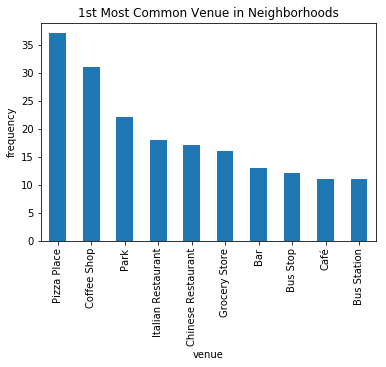

In [64]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

df_bar.plot(kind='bar')
plt.title('1st Most Common Venue in Neighborhoods')
plt.ylabel('frequency')
plt.xlabel('venue')
plt.show()

**Step 7: Let us run K-means clustering to identify similar clusters between New York and Toronto neighborhoods**

In [52]:
# set number of clusters
kclusters = 5

combo_grouped_clustering = combo_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(combo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 3, 3, 3, 3, 1, 1, 1, 1, 1], dtype=int32)

In [54]:
#add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

combo_merged = df_combo

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
combo_merged = combo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

combo_merged.head() # check the last columns!

Borough                                 Neighborhood  \
Toronto 0        North York                                    Parkwoods   
        1        North York                             Victoria Village   
        2  Downtown Toronto                    Regent Park, Harbourfront   
        3        North York             Lawrence Manor, Lawrence Heights   
        4  Downtown Toronto  Queen's Park, Ontario Provincial Government   

            Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
Toronto 0  43.753259 -79.329656             0.0     Food & Drink Shop   
        1  43.725882 -79.315572             1.0         Grocery Store   
        2  43.654260 -79.360636             1.0           Coffee Shop   
        3  43.718518 -79.464763             1.0        Clothing Store   
        4  43.662301 -79.389494             1.0           Coffee Shop   

            2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
Toronto 0                    Park       Fireworks Store    Falafel Restaurant   
        1   Portuguese Restaurant           Coffee Shop          Hockey Arena   
        2                  Bakery                  Park                   Pub   
        3  Furniture / Home Store              Boutique           Coffee Shop   
        4        Sushi Restaurant              Beer Bar    College Auditorium   

                 5th Most Common Venue 6th Most Common Venue  \
Toronto 0  Eastern European Restaurant   Egyptian Restaurant   
        1                Women's Store               Factory   
        2               Breakfast Spot                  Café   
        3           Miscellaneous Shop             Gift Shop   
        4                         Park                   Gym   

           7th Most Common Venue        8th Most Common Venue  \
Toronto 0      Electronics Store          Empanada Restaurant   
        1         Duty-free Shop  Eastern European Restaurant   
        2             Restaurant                      Theater   
        3  Vietnamese Restaurant                  Event Space   
        4         Sandwich Place                         Bank   

          9th Most Common Venue 10th Most Common Venue  
Toronto 0    English Restaurant  Entertainment Service  
        1   Egyptian Restaurant      Electronics Store  
        2        Cosmetics Shop                   Bank  
        3     Accessories Store   Ethiopian Restaurant  
        4                   Bar            Yoga Studio

In [55]:
combo_merged.tail()

Borough  Neighborhood   Latitude  Longitude  \
New York 301      Manhattan  Hudson Yards  40.756658 -74.000111   
         302         Queens       Hammels  40.587338 -73.805530   
         303         Queens     Bayswater  40.611322 -73.765968   
         304         Queens  Queensbridge  40.756091 -73.945631   
         305  Staten Island     Fox Hills  40.617311 -74.081740   

              Cluster Labels       1st Most Common Venue  \
New York 301             1.0                       Hotel   
         302             1.0                       Beach   
         303             1.0  Construction & Landscaping   
         304             1.0                       Hotel   
         305             1.0                    Bus Stop   

             2nd Most Common Venue 3rd Most Common Venue  \
New York 301    Italian Restaurant   American Restaurant   
         302                 Diner              Building   
         303            Playground         Women's Store   
         304        Sandwich Place        Scenic Lookout   
         305        Sandwich Place         Women's Store   

                    4th Most Common Venue 5th Most Common Venue  \
New York 301         Gym / Fitness Center                   Gym   
         302                      Dog Run  Fast Food Restaurant   
         303                         Farm        Duty-free Shop   
         304                  Beer Garden    Athletics & Sports   
         305  Eastern European Restaurant   Egyptian Restaurant   

                    6th Most Common Venue 7th Most Common Venue  \
New York 301                         Café                  Park   
         302                   Shoe Store              Bus Stop   
         303  Eastern European Restaurant   Egyptian Restaurant   
         304               Baseball Field  Gym / Fitness Center   
         305            Electronics Store   Empanada Restaurant   

             8th Most Common Venue  9th Most Common Venue  \
New York 301         Boat or Ferry              Nightclub   
         302           Bus Station          Deli / Bodega   
         303     Electronics Store    Empanada Restaurant   
         304              Platform              Roof Deck   
         305    English Restaurant  Entertainment Service   

             10th Most Common Venue  
New York 301             Restaurant  
         302   Gym / Fitness Center  
         303     English Restaurant  
         304  Performing Arts Venue  
         305   Ethiopian Restaurant

**Step 8: Now let us map: create map equidistant between Toronto and New York**

In [56]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [57]:
address = 'New York, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


In [58]:
latitude = (40.7127281 + 43.6534817)/2
latitude

42.183104900000004

In [59]:
longitude = (-74.0060152 - 79.3839347) / 2
longitude

-76.69497494999999

In [61]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(combo_merged['Latitude'], combo_merged['Longitude'], combo_merged['Neighborhood'], combo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow,
        fill=True,
        fill_color=rainbow,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Step 9: Let us review Cluster 1 - the Cluster of Somerville**

In [62]:
combo_merged.loc[combo_merged['Cluster Labels'] == 0, combo_merged.columns[[1] + list(range(5, combo_merged.shape[1]))]]

Neighborhood  \
Toronto  0                                            Parkwoods   
         21                                 Caledonia-Fairbanks   
         35       East Toronto, Broadview North (Old East York)   
         61                                       Lawrence Park   
         64                                              Weston   
         66                                     York Mills West   
         83                         Moore Park, Summerhill East   
         85   Milliken, Agincourt North, Steeles East, L'Amo...   
         98       The Kingsway, Montgomery Road, Old Mill North   
New York 27                                        Clason Point   
         192                                         Somerville   
         203                                          Todt Hill   

             1st Most Common Venue 2nd Most Common Venue  \
Toronto  0       Food & Drink Shop                  Park   
         21                   Park         Women's Store   
         35      Convenience Store         Metro Station   
         61               Bus Line           Swim School   
         64                   Park     Convenience Store   
         66      Convenience Store                  Park   
         83                    Gym                  Park   
         85                   Park            Playground   
         98                   Park                 River   
New York 27                   Park     Convenience Store   
         192                  Park         Women's Store   
         203                  Park                 Trail   

             3rd Most Common Venue        4th Most Common Venue  \
Toronto  0         Fireworks Store           Falafel Restaurant   
         21                   Pool                         Farm   
         35                   Park                 Intersection   
         61                   Park                  Flower Shop   
         64    Dumpling Restaurant  Eastern European Restaurant   
         66    Dumpling Restaurant  Eastern European Restaurant   
         83          Women's Store           Falafel Restaurant   
         85          Women's Store                         Farm   
         98          Women's Store                         Farm   
New York 27                   Pool    South American Restaurant   
         192   Dumpling Restaurant  Eastern European Restaurant   
         203         Women's Store           Falafel Restaurant   

                    5th Most Common Venue        6th Most Common Venue  \
Toronto  0    Eastern European Restaurant          Egyptian Restaurant   
         21   Eastern European Restaurant          Egyptian Restaurant   
         35   Eastern European Restaurant          Egyptian Restaurant   
         61                   Flea Market  Eastern European Restaurant   
         64           Egyptian Restaurant            Electronics Store   
         66           Egyptian Restaurant            Electronics Store   
         83   Eastern European Restaurant          Egyptian Restaurant   
         85   Eastern European Restaurant          Egyptian Restaurant   
         98   Eastern European Restaurant          Egyptian Restaurant   
New York 27                      Bus Stop                Boat or Ferry   
         192          Egyptian Restaurant            Electronics Store   
         203  Eastern European Restaurant          Egyptian Restaurant   

             7th Most Common Venue 8th Most Common Venue  \
Toronto  0       Electronics Store   Empanada Restaurant   
         21      Electronics Store   Empanada Restaurant   
         35      Electronics Store   Empanada Restaurant   
         61    Egyptian Restaurant     Electronics Store   
         64    Empanada Restaurant    English Restaurant   
         66    Empanada Restaurant    English Restaurant   
         83      Electronics Store   Empanada Restaurant   
         85      Electronics Store   Empanada Restaurant   
         98      Electr

In [65]:
len(combo_merged.loc[combo_merged['Cluster Labels'] == 0, combo_merged.columns[[1] + list(range(5, combo_merged.shape[1]))]])

12

**Explanation** 


This cluster can be characterized as:
- Being close to parks, gyms, women's stores.
- Having a high concentration of Mediterranean, Eastern European and empanada restaurants.
- Open spaces.
- Unique areas, e.g. flea markets, flowers shops, farms.

There are 9 locations similar to Somerville neighborhood in Toronto.

As Fresh Tiki considers opening various locations in Toronto, there are 9 possible neighborhoods that provide the same feel.  These neighborhoods include:
1. Parkwoods
2. Caledonia-Fairbanks
3. East Toronto, Broadview North
4. Lawrence Park
5. Weston
6. York Mills West
7. Moore Park, Summerhill East
8. Mililikwn, Agincourt North, Steeles East
9. The Kingsway, Montgomery Road, Old Mill North

**Step 10: Please let us consider other clusters as well**

In [66]:
combo_merged.loc[combo_merged['Cluster Labels'] == 1, combo_merged.columns[[1] + list(range(5, combo_merged.shape[1]))]]

Neighborhood  \
Toronto  1                                     Victoria Village   
         2                            Regent Park, Harbourfront   
         3                     Lawrence Manor, Lawrence Heights   
         4          Queen's Park, Ontario Provincial Government   
         6                                       Malvern, Rouge   
         7                                            Don Mills   
         9                             Garden District, Ryerson   
         12              Rouge Hill, Port Union, Highland Creek   
         13                                           Don Mills   
         14                                    Woodbine Heights   
         15                                      St. James Town   
         16                                  Humewood-Cedarvale   
         18                   Guildwood, Morningside, West Hill   
         19                                         The Beaches   
         20                                         Berczy Park   
         22                                              Woburn   
         23                                             Leaside   
         24                                  Central Bay Street   
         25                                            Christie   
         26                                           Cedarbrae   
         27                                   Hillcrest Village   
         28     Bathurst Manor, Wilson Heights, Downsview North   
         29                                    Thorncliffe Park   
         30                            Richmond, Adelaide, King   
         31                        Dufferin, Dovercourt Village   
         32                                 Scarborough Village   
         33                        Fairview, Henry Farm, Oriole   
         34                     Northwood Park, York University   
         36   Harbourfront East, Union Station, Toronto Islands   
         37                            Little Portugal, Trinity   
         38         Kennedy Park, Ionview, East Birchmount Park   
         39                                     Bayview Village   
         40                                           Downsview   
         41                        The Danforth West, Riverdale   
         42            Toronto Dominion Centre, Design Exchange   
         43        Brockton, Parkdale Village, Exhibition Place   
         44                     Golden Mile, Clairlea, Oakridge   
         45                            York Mills, Silver Hills   
         46                                           Downsview   
         47                      India Bazaar, The Beaches West   
         48                      Commerce Court, Victoria Hotel   
         49            North Park, Maple Leaf Park, Upwood Park   
         51     Cliffside, Cliffcrest, Scarborough Village West   
         53                                           Downsview   
         54                                     Studio District   
         55                   Bedford Park, Lawrence Manor East   
         56    Del Ray, Mount Dennis, Keelsdale and Silverthorn   
         58                         Birch Cliff, Cliffside West   
         59                         Willowdale, Willowdale East   
         60                                           Downsview   
         62                                            Roselawn   
         65   Dorset Park, Wexford Heights, Scarborough Town...   
         67                                    Davisville North   
         68     Forest Hill North & West, Forest Hill Road Park   
         69                       High Park, The Junction South   
         71                                   Wexford, Maryvale   
         73                   North Toronto West, Lawrence Park   
         74                 The Annex, North Midtown, Yorkville   
         75                              Parkdale, Roncesvalles   
         76               Canad

In [72]:
len(combo_merged.loc[combo_merged['Cluster Labels'] == 1, combo_merged.columns[[1] + list(range(5, combo_merged.shape[1]))]])

300

In [132]:
combo_merged.loc[combo_merged['Cluster Labels'] == 2, combo_merged.columns[[1] + list(range(5, combo_merged.shape[1]))]]

Neighborhood  \
Toronto 57                                    Humberlea, Emery   
        101  Old Mill South, King's Mill Park, Sunnylea, Hu...   

            1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
Toronto 57         Baseball Field          Food Service         Women's Store   
        101        Baseball Field         Women's Store                  Farm   

                   4th Most Common Venue        5th Most Common Venue  \
Toronto 57                          Farm  Eastern European Restaurant   
        101  Eastern European Restaurant          Egyptian Restaurant   

            6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
Toronto 57    Egyptian Restaurant     Electronics Store   Empanada Restaurant   
        101     Electronics Store   Empanada Restaurant    English Restaurant   

             9th Most Common Venue 10th Most Common Venue  
Toronto 57      English Restaurant  Entertainment Service  
        101  Entertainment Service   Ethiopian Restaurant

In [67]:
len(combo_merged.loc[combo_merged['Cluster Labels'] == 2, combo_merged.columns[[1] + list(range(5, combo_merged.shape[1]))]])

2

In [68]:
combo_merged.loc[combo_merged['Cluster Labels'] == 3, combo_merged.columns[[1] + list(range(5, combo_merged.shape[1]))]]

Neighborhood  \
Toronto  8                      Parkview Hill, Woodbine Gardens   
         10                                           Glencairn   
         17   Eringate, Bloordale Gardens, Old Burnhamthorpe...   
         50                                       Humber Summit   
         63                       Runnymede, The Junction North   
         70                                           Westmount   
         72                         Willowdale, Willowdale West   
         77   Kingsview Village, St. Phillips, Martin Grove ...   
         82             Clarks Corners, Tam O'Shanter, Sullivan   
         89   South Steeles, Silverstone, Humbergate, Jamest...   
         93                              Alderwood, Long Branch   
New York 5                                          Kingsbridge   
         7                                             Woodlawn   
         8                                              Norwood   
         11                                      Pelham Parkway   
         14                                  University Heights   
         15                                      Morris Heights   
         17                                        East Tremont   
         19                                        High  Bridge   
         20                                             Melrose   
         21                                          Mott Haven   
         28                                         Throgs Neck   
         30                                         Parkchester   
         32                                            Van Nest   
         33                                         Morris Park   
         34                                             Belmont   
         36                                     North Riverdale   
         38                                       Schuylerville   
         39                                      Edgewater Park   
         40                                         Castle Hill   
         42                                      Pelham Gardens   
         48                                         Sunset Park   
         50                                           Gravesend   
         53                                   Manhattan Terrace   
         55                                       Crown Heights   
         72                                       East New York   
         73                                       Starrett City   
         80                                        Borough Park   
         83                                         Marine Park   
         92                                             Midwood   
         98                                       Ocean Parkway   
         137                                      Richmond Hill   
         140                                          Sunnyside   
         142                                            Maspeth   
         144                                           Glendale   
         149                                      College Point   
         154                                         Douglaston   
         156                                          Bellerose   
         157                                  Kew Gardens Hills   
         158                                      Fresh Meadows   
         164                                      South Jamaica   
         170                                       Far Rockaway   
         171                                      Broad Channel   
         181                                        Floral Park   
         195                                       North Corona   
         205                                      Port Richmond   
         206                                   Mariner's Harbor   
         208                                  Castleton Corners   
         211                                           New Dorp   
         213                   

In [70]:
len(combo_merged.loc[combo_merged['Cluster Labels'] == 3, combo_merged.columns[[1] + list(range(5, combo_merged.shape[1]))]])

86

In [69]:
combo_merged.loc[combo_merged['Cluster Labels'] == 4, combo_merged.columns[[1] + list(range(5, combo_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
New York 179     Neponsit                 Beach             Beach Bar   
         193   Brookville         Deli / Bodega         Women's Store   
         202  Grymes Hill               Dog Run         Deli / Bodega   
         204  South Beach         Deli / Bodega                  Pier   

             3rd Most Common Venue        4th Most Common Venue  \
New York 179         Women's Store               Farmers Market   
         193        Farmers Market  Eastern European Restaurant   
         202         Women's Store               Farmers Market   
         204    Athletics & Sports                        Beach   

             5th Most Common Venue 6th Most Common Venue  \
New York 179     Electronics Store   Empanada Restaurant   
         193   Egyptian Restaurant     Electronics Store   
         202   Egyptian Restaurant     Electronics Store   
         204         Women's Store                  Farm   

             7th Most Common Venue  8th Most Common Venue  \
New York 179    English Restaurant  Entertainment Service   
         193   Empanada Restaurant     English Restaurant   
         202   Empanada Restaurant     English Restaurant   
         204   Egyptian Restaurant      Electronics Store   

              9th Most Common Venue 10th Most Common Venue  
New York 179   Ethiopian Restaurant            Event Space  
         193  Entertainment Service   Ethiopian Restaurant  
         202  Entertainment Service   Ethiopian Restaurant  
         204    Empanada Restaurant     English Restaurant

In [71]:
len(combo_merged.loc[combo_merged['Cluster Labels'] == 4, combo_merged.columns[[1] + list(range(5, combo_merged.shape[1]))]])

4

**Summary**

It seems like we are about to complete the project.

Mr. Xi, through this analysis, can be provided a good understanding of the various neighborhoods in Toronto.  

In addition, Mr. Xi can been able to short-list 9 possible neighborhoods in Toronto for the opening of the restaurants.  Based on the shortlist, Mr. Xi can identify the location for the first five locations through a site visit.

Please see the full report and presentation.  I hope you enjoy reading it.

**Just a quick map of Somerville**

In [75]:
folium.Map(location=[40.5743, -74.6099], zoom_start=14)